In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import p5lib

%matplotlib inline

In [2]:
data = pd.read_csv('MERGED2013_PP.csv')
print "Number of features: {}".format(len(data.columns))
print "Number of rows: {}".format(len(data))

Number of features: 1729
Number of rows: 7804


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7,9,1427,1542,1561,1575,1725,1726,1727,1728) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = p5lib.preprocess_data(data)
print "Num data after preprocessing: {}".format(len(data))
print "Num features: {}".format(len(data.columns))
# print data.shape


Num data after preprocessing: 6007
Num features: 45


In [20]:
selected_features = ['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'C150', 'RET_FT']
X = data[selected_features].dropna()
y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape

# print X.PFTFTUG1_EF.describe()

(1210, 25)
(1210, 2)


In [38]:
from sklearn import preprocessing

# tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
#           'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A']]
# scaler = preprocessing.MinMaxScaler()
# scaledX = scaler.fit_transform(tmpX)
# pctX = X[['PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
#           'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL']]
# pctX = np.array(pctX)
# forPcaX = np.concatenate((scaledX, pctX), axis=1)
# print forPcaX.shape

tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.StandardScaler()
forPcaX = scaler.fit_transform(tmpX)
print forPcaX.shape

(1210, 23)


In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=forPcaX.shape[1])
pca.fit(forPcaX)

# print pca.components_
print pca.explained_variance_ratio_


[  3.61448338e-01   1.60225813e-01   9.03945924e-02   7.37503475e-02
   6.59417566e-02   4.55909843e-02   3.48239856e-02   2.68635652e-02
   2.29647586e-02   1.98769269e-02   1.93667645e-02   1.59849191e-02
   1.40968240e-02   1.16973258e-02   9.89668434e-03   9.22112533e-03
   6.36891416e-03   4.01930561e-03   3.41721299e-03   2.80217633e-03
   1.24767981e-03   8.25017351e-19   2.22500832e-19]


In [40]:
pca = PCA(n_components=12)
pca.fit(forPcaX)
reducedX = pca.transform(forPcaX)
print reducedX.shape

(1210, 12)


In [41]:
# add the categorical feature

tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 
print tmp1X.shape
print tmp2X.shape
print reducedX.shape
finalX = np.concatenate((reducedX, tmp1X, tmp2X), axis=1)
print finalX.shape

(1210, 3)
(1210, 1)
(1210, 12)
(1210, 16)


In [42]:
from sklearn import metrics
from sklearn import cross_validation as cv
from sklearn.tree import DecisionTreeRegressor

y = np.array(y)
X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(968, 16)
(242, 16)
(968, 2)
(242, 2)


In [43]:
from sklearn import metrics
from sklearn import metrics
from sklearn import cross_validation as cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

def print_r2score(reg, X, y, test=False):
    t = 'test ' if test else 'train'
    r2score = metrics.r2_score(y, reg.predict(np.array(X)))
    print "R2 score on {} data: {}".format(t, r2score)
    return r2score

def print_mse(reg, X, y, test=False):
    t = 'test ' if test else 'train'
    mse = metrics.mean_squared_error(y, reg.predict(np.array(X)))
    print "MSE on {} data: {}".format(t, mse)
    return mse

def print_mae(reg, X, y, test=False):
    t = 'test ' if test else 'train'
    mae = metrics.mean_absolute_error(y, reg.predict(np.array(X)))
    print "MAE on {} data: {}".format(t, mae)
    return mae

r2_scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)
mse_scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)
mae_scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False)
default_scorer = mse_scorer

def split_y(y_train, y_test):
    return y_train[:,0], y_test[:,0], y_train[:,1], y_test[:,1]

def print_r2_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test):
    print "--- R2 Completion ---"
    if hasattr(reg1, 'best_params_'):
        print "best params: {}".format(reg1.best_params_)
    r2_train_reg1 = print_r2score(reg1, X_train, y1_train)
    r2_test_reg1  = print_r2score(reg1, X_test, y1_test, test=True)

    print "--- R2 Retention ---"
    if hasattr(reg2, 'best_params_'):
        print "best params: {}".format(reg2.best_params_)
    r2_train_reg2 = print_r2score(reg2, X_train, y2_train)
    r2_test_reg2  = print_r2score(reg2, X_test, y2_test, test=True)

    return {'reg1': {'train': r2_train_reg1, 'test': r2_test_reg1 },
            'reg2': {'train': r2_train_reg2, 'test': r2_test_reg2 }}

def print_mse_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test):
    print "--- MSE Completion ---"
    mse_train_reg1 = print_mse(reg1, X_train, y1_train)
    mse_test_reg1 = print_mse(reg1, X_test, y1_test, test=True)
    print "--- MSE Retention ---"
    mse_train_reg2 = print_mse(reg2, X_train, y2_train)
    mse_test_reg2 = print_mse(reg2, X_test, y2_test, test=True)
    return {'reg1': {'train': mse_train_reg1, 'test': mse_test_reg1 },
            'reg2': {'train': mse_train_reg2, 'test': mse_test_reg2 }}

def print_mae_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test):
    print "--- MAE Completion ---"
    mae_train_reg1 = print_mae(reg1, X_train, y1_train)
    mae_test_reg1 = print_mae(reg1, X_test, y1_test, test=True)
    print "--- MAE Retention ---"
    mae_train_reg2 = print_mae(reg2, X_train, y2_train)
    mae_test_reg2 = print_mae(reg2, X_test, y2_test, test=True)
    return {'reg1': {'train': mae_train_reg1, 'test': mae_test_reg1 },
            'reg2': {'train': mae_train_reg2, 'test': mae_test_reg2 }}

def plot_err_metric(err, metric=None, model=None):
    plt.title('{} - {}'.format(metric, model))
    plt.bar(np.array(range(2)), [err['reg1']['train'], err['reg2']['train']], width=0.4, color='r')
    plt.bar(np.array(range(2))+0.4, [err['reg1']['test'], err['reg2']['test']], width=0.4, color='b')
    plt.ylabel(metric)
    plt.legend(['Train', 'Test'])
    plt.xticks(np.array(range(4))+ 0.4, ['Completion', 'Retention'])
    plt.show()
    
def build_DecisionTree_model(X_train, X_test, y_train, y_test, cv=3, scorer=None):
    if scorer == None:
        scorer = default_scorer
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    parameters = {'max_depth': range(1,10)} # , 'min_samples_leaf': [4,5,6,7]}
    reg = DecisionTreeRegressor()
    best_reg1 = GridSearchCV(reg, parameters, scoring=scorer, cv=cv)
    best_reg1.fit(X_train, y1_train)

    reg = DecisionTreeRegressor()
    best_reg2 = GridSearchCV(reg, parameters, scoring=scorer, cv=cv)
    best_reg2.fit(X_train, y2_train)

    r2 = print_r2_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mse = print_mse_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mae = print_mae_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    plot_err_metric(r2, metric='R2 score', model='Decision Tree')
    plot_err_metric(mse, metric='MSE', model='Decision Tree')
    plot_err_metric(mae, metric='MAE', model='Decision Tree')
    
    return {'reg1': best_reg1, 'reg2': best_reg2, 'r2': r2, 'mse': mse, 'mae': mae}


--- R2 Completion ---
best params: {'max_depth': 4}
R2 score on train data: 0.774393611459
R2 score on test  data: 0.716294896476
--- R2 Retention ---
best params: {'max_depth': 4}
R2 score on train data: 0.655944189928
R2 score on test  data: 0.631448790152
--- MSE Completion ---
MSE on train data: 0.00614607225276
MSE on test  data: 0.00809926500771
--- MSE Retention ---
MSE on train data: 0.00426297395114
MSE on test  data: 0.00530363890899
--- MAE Completion ---
MAE on train data: 0.0603936380217
MAE on test  data: 0.0699674551324
--- MAE Retention ---
MAE on train data: 0.048807265975
MAE on test  data: 0.0546591951072


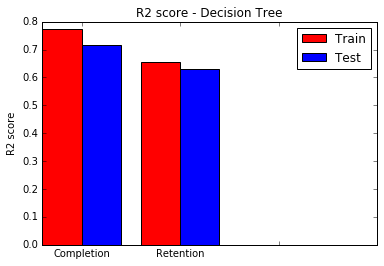

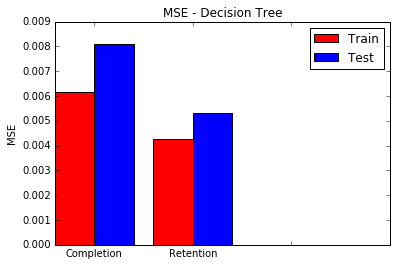

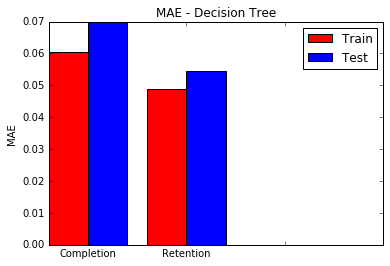

In [45]:
# DT_reg1, DT_reg2, _, _ = p5lib.build_DecisionTree_model(X_train, X_test, y_train, y_test)
DT_model = build_DecisionTree_model(X_train, X_test, y_train, y_test)

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 10.0, 'gamma': 0.10000000000000001}
R2 score on train data: 0.843761390777
R2 score on test  data: 0.704637067976
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.632302378838
R2 score on test  data: 0.54057384038
--- MSE Completion ---
MSE on train data: 0.00425632353394
MSE on test  data: 0.00843207482068
--- MSE Retention ---
MSE on train data: 0.00455590440568
MSE on test  data: 0.00661137554527
--- MAE Completion ---
MAE on train data: 0.0557992943322
MAE on test  data: 0.0729377323009
--- MAE Retention ---
MAE on train data: 0.0531372207731
MAE on test  data: 0.0628821786403


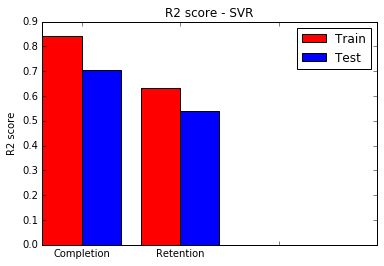

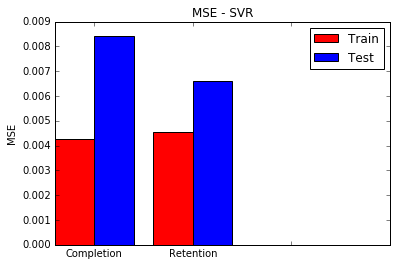

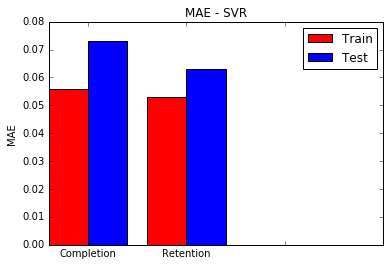

In [46]:
def build_SVR_model(X_train, X_test, y_train, y_test, cv=3, params=None, scorer=None):
    if scorer == None:
        scorer = default_scorer
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    if params == None:
        params = {'C': np.logspace(-1, 1, 2), 'gamma': np.logspace(-1, 1, 2), 'epsilon': np.logspace(-1, 1, 2)}
    reg = SVR()
    best_reg1 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    best_reg1.fit(X_train, y1_train)

    reg = SVR()
    best_reg2 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    best_reg2.fit(X_train, y2_train)

    r2 = print_r2_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mse = print_mse_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mae = print_mae_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    plot_err_metric(r2, metric='R2 score', model='SVR')
    plot_err_metric(mse, metric='MSE', model='SVR')
    plot_err_metric(mae, metric='MAE', model='SVR')
    
    return {'reg1': best_reg1, 'reg2': best_reg2, 'r2': r2, 'mse': mse, 'mae': mae}

# SVR_reg1, SVR_reg2, _, _ = p5lib.build_SVR_model(X_train, X_test, y_train, y_test, cv=3)
SVR_model = build_SVR_model(X_train, X_test, y_train, y_test, cv=3)

--- R2 Completion ---
best params: {'n_neighbors': 9}
R2 score on train data: 0.81717035733
R2 score on test  data: 0.742456132271
--- R2 Retention ---
best params: {'n_neighbors': 11}
R2 score on train data: 0.710405446202
R2 score on test  data: 0.66582395394
--- MSE Completion ---
MSE on train data: 0.00498072860907
MSE on test  data: 0.00735240927971
--- MSE Retention ---
MSE on train data: 0.00358817960078
MSE on test  data: 0.00480896286046
--- MAE Completion ---
MAE on train data: 0.0530898212721
MAE on test  data: 0.0663693624603
--- MAE Retention ---
MAE on train data: 0.0409454357626
MAE on test  data: 0.0509466566491


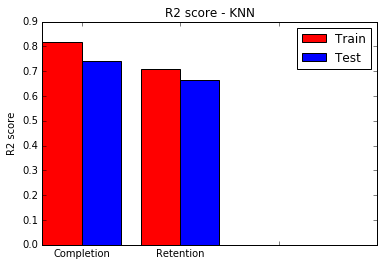

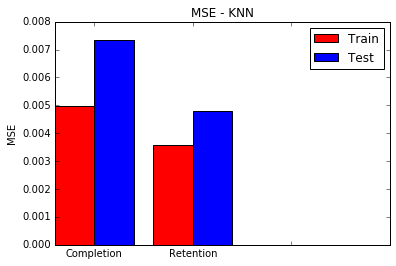

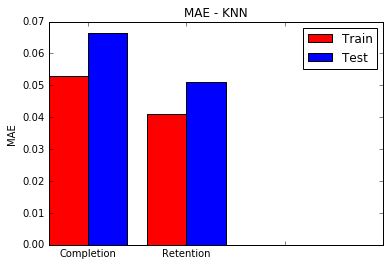

In [47]:
def build_KNN_model(X_train, X_test, y_train, y_test, cv=3, scorer=None):
    if scorer == None:
        scorer = default_scorer
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    parameters = {'n_neighbors': range(5,20)}
    reg = KNeighborsRegressor()
    best_reg1 = GridSearchCV(reg, parameters, scoring=scorer, cv=cv)
    best_reg1.fit(X_train, y1_train)

    parameters = {'n_neighbors': range(5, 20)}
    reg = KNeighborsRegressor()
    best_reg2 = GridSearchCV(reg, parameters, scoring=scorer, cv=cv)
    best_reg2.fit(X_train, y2_train)

    r2 = print_r2_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mse = print_mse_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mae = print_mae_summary(best_reg1, best_reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    plot_err_metric(r2, metric='R2 score', model='KNN')
    plot_err_metric(mse, metric='MSE', model='KNN')
    plot_err_metric(mae, metric='MAE', model='KNN')
    
    return {'reg1': best_reg1, 'reg2': best_reg2, 'r2': r2, 'mse': mse, 'mae': mae}

# KNN_reg1, KNN_reg2, _, _ = p5lib.build_KNN_model(X_train, X_test, y_train, y_test)
KNN_model = build_KNN_model(X_train, X_test, y_train, y_test)

--- R2 Completion ---
R2 score on train data: 0.968350168971
R2 score on test  data: 0.775585052005
--- R2 Retention ---
R2 score on train data: 0.942771394431
R2 score on test  data: 0.676282336102
--- MSE Completion ---
MSE on train data: 0.000862219148808
MSE on test  data: 0.00640663884058
--- MSE Retention ---
MSE on train data: 0.00070908279314
MSE on test  data: 0.00465846143467
--- MAE Completion ---
MAE on train data: 0.0223201072339
MAE on test  data: 0.0612602419533
--- MAE Retention ---
MAE on train data: 0.0175831898736
MAE on test  data: 0.0490550794831


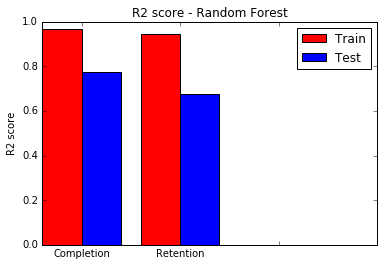

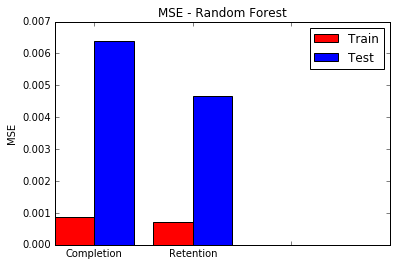

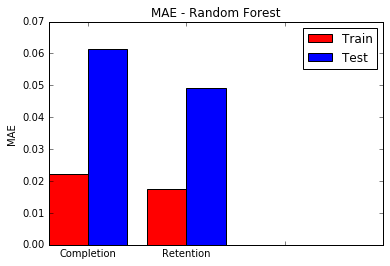

In [48]:
def build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=10, scorer=None):
    if scorer == None:
        scorer = default_scorer
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    reg1 = RandomForestRegressor(n_estimators=n_estimators)
    reg1.fit(X_train, y1_train)

    reg2 = RandomForestRegressor(n_estimators=n_estimators)
    reg2.fit(X_train, y2_train)

    r2 = print_r2_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mse = print_mse_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    mae = print_mae_summary(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test)
    plot_err_metric(r2, metric='R2 score', model='Random Forest')
    plot_err_metric(mse, metric='MSE', model='Random Forest')
    plot_err_metric(mae, metric='MAE', model='Random Forest')
    
    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

RF_model = build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=50)

In [52]:
X_all = data[selected_features].copy()

fill_cols_with_mean = ['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'WDRAW_DEBT_MDN',
                       'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 
                       'UG25abv', 'NPT4', 'NUM4', 'PFTFTUG1_EF', 'PFTFAC', 'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 
                       'AVGFACSAL', 'COSTT4_A']

for col in fill_cols_with_mean:
    if col in X:
        X_all[col] = X_all[col].fillna(X_all[col].mean())

print X_all.shape
print len(X_all.dropna()) # check there is no missing values

(6007, 27)
6007


In [53]:
y1_all = X_all.C150 # X_all[['C150']]
y2_all = X_all.RET_FT # X_all[['RET_FT']]
X_all = X_all.drop('C150', 1)
X_all = X_all.drop('RET_FT', 1)

print X_all.shape
print y1_all.shape
print y2_all.shape



(6007, 25)
(6007,)
(6007,)


In [54]:
tmpX = X_all[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.StandardScaler()
forPcaX = scaler.fit_transform(tmpX)
print forPcaX.shape

pca = PCA(n_components=forPcaX.shape[1])
pca.fit(forPcaX)

# print pca.components_
print pca.explained_variance_ratio_

pca = PCA(n_components=12)
pca.fit(forPcaX)
reducedX = pca.transform(forPcaX)
print reducedX.shape


(6007, 23)
[  3.26050265e-01   1.24247742e-01   9.69326766e-02   6.89817577e-02
   5.78529489e-02   4.73543591e-02   4.23201606e-02   3.93261019e-02
   3.45064550e-02   2.76951539e-02   2.50172373e-02   2.22565806e-02
   2.20522227e-02   1.60085311e-02   1.16593703e-02   9.29566488e-03
   7.59550950e-03   7.36636142e-03   4.94938204e-03   4.59693586e-03
   3.00392943e-03   6.09099409e-04   3.21554733e-04]
(6007, 12)


In [59]:

tmp1X = np.array(pd.get_dummies(X_all['CONTROL']))
tmp2X = X_all['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 
print tmp1X.shape
print tmp2X.shape
print reducedX.shape
finalX = np.concatenate((reducedX, tmp1X, tmp2X), axis=1)
print finalX.shape

print_r2score(SVR_model['reg1'], finalX, y1_all)
print_mae(SVR_model['reg1'], finalX, y1_all)
print_mse(SVR_model['reg1'], finalX, y1_all)

(6007, 3)
(6007, 1)
(6007, 12)
(6007, 16)
R2 score on train data: -0.00980699176305
MAE on train data: 0.203628753924
MSE on train data: 0.0569727990865


0.056972799086525965